# AutoEncoder with MNIST

In [1]:
__reference__ = "https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py"

import torch
from torch.autograd import Variable
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


!nvidia-smi
!lscpu |grep 'Model name'
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'
#hard disk that we can use
!df -h / | awk '{print $4}'

0it [00:00, ?it/s]

9920512it [00:02, 3680321.67it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 58189.33it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 972817.30it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 21716.83it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Tue Oct 29 05:25:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------------------------------------------------------------------------

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
4


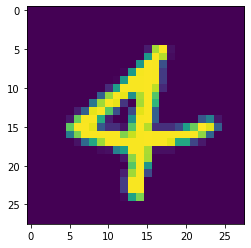

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

image, label = train_dataset[150]

plt.imshow(image[0])
print(label)

# AutoEncoder

In [0]:
class autoencoder(nn.Module):
  def __init__(self, input_size):
    super(autoencoder,self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU(True),
        nn.Linear(128,64),
        nn.ReLU(True),
        nn.Linear(64,12),
        nn.ReLU(True),
        nn.Linear(12,4)
    )
    self.decoder = nn.Sequential(
        nn.Linear(4, 12),
        nn.ReLU(True),
        nn.Linear(12, 64),
        nn.ReLU(True),
        nn.Linear(64, 128),
        nn.ReLU(True), 
        nn.Linear(128, input_size)
    )
    
  def forward(self, x):
    h = self.encoder(x)
    o = self.decoder(h)
    return o

   

In [0]:
input_size = 28*28
model = autoencoder(input_size)
model = model.cuda()
criterion = torch.nn.MSELoss()
#criterion = torch.nn.MSELoss(reduction='sum')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)


In [0]:
def to_img(x):
  print(x.shape)
  x = 0.5 * (x + 1)
  x = x.clamp(0, 1)
  x = x.view(x.size(0), 1, 28, 28)
  return x

# Let's see the output before training

input


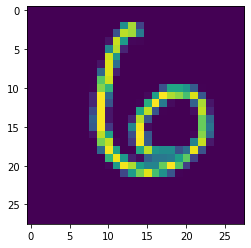

In [6]:
## Before training
test_image, label = test_dataset[100]
print("input")
plt.imshow(test_image[0])



Output


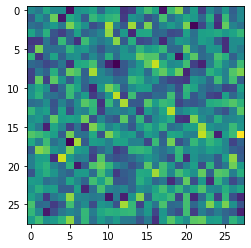

In [7]:
test_image = test_image.cuda()
test_image = test_image.view(test_image.size(0), -1)
test_image = Variable(test_image)
print("Output")
test_output_1 = model(test_image)
test_output_1 = test_output_1.cpu().detach().numpy()
test_output_1 = test_output_1.reshape(28,28)
plt.imshow(test_output_1)

In [8]:
MSE = np.sum(np.square(test_output_1 - test_image.cpu().data.numpy().reshape(28,28)))
print('before training, MSE = ', MSE)

before training, MSE =  54.875164


# After training 1 epoch

In [9]:
num_epochs = 1
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
for epoch in range(num_epochs):
  for data in train_loader:
    img, _ = data
    img = img.cuda()
    img = img.view(img.size(0), -1)
    img = Variable(img)
    #print(img.shape)
    output = model(img)
    
    loss = criterion(output, img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # ===================log========================
  
  if((epoch+1)%10==0):
    print('epoch [{}/{}], train_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    for test_data in test_loader:
      img, _ = test_data
      img = img.cuda()
      img = img.view(img.size(0), -1)
      img = Variable(img)
      #print(img.shape)
      test_output = model(img)
      # print(test_output.shape)
      test_loss = criterion(test_output, img)
    print("test_loss = ", epoch+1)
    print("{}".format(test_loss))
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))


9757.8017578125


Output


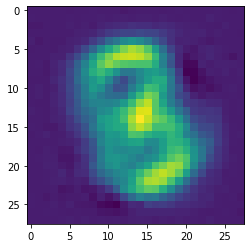

In [10]:
test_image = test_image.cuda()
test_image = test_image.view(test_image.size(0), -1)
test_image = Variable(test_image)
print("Output")
test_output_2 = model(test_image)
test_output_2 = test_output_2.cpu().detach().numpy()
test_output_2 = test_output_2.reshape(28,28)
plt.imshow(test_output_2)

In [11]:
MSE = np.sum(np.square(test_output_2 - test_image.cpu().data.numpy().reshape(28,28)))
print('After 1 epoch training, MSE = ', MSE)

After 1 epoch training, MSE =  37.220924


# After training 5 epochs...

In [12]:
num_epochs = 5
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
for epoch in range(num_epochs):
  for data in train_loader:
    img, _ = data
    img = img.cuda()
    img = img.view(img.size(0), -1)
    img = Variable(img)
    output = model(img)
    
    loss = criterion(output, img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # ===================log========================
  
  if((epoch+1)%10==0) or True:
    print('epoch [{}/{}], train_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    for test_data in test_loader:
      img, _ = test_data
      img = img.cuda()
      img = img.view(img.size(0), -1)
      img = Variable(img)
      # print(img.shape)
      test_output = model(img)
      # print(test_output.shape)
      test_loss = criterion(test_output, img)
    print("test_loss = ", epoch+1)
    print("{}".format(test_loss))
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))


epoch [1/5], train_loss:0.0425
test_loss =  1
0.044097840785980225
epoch [2/5], train_loss:0.0387
test_loss =  2
0.039414022117853165
epoch [3/5], train_loss:0.0365
test_loss =  3
0.03733072057366371
epoch [4/5], train_loss:0.0347
test_loss =  4
0.036905109882354736
epoch [5/5], train_loss:0.0381
test_loss =  5
0.03641229122877121
54422.953125


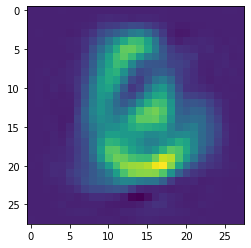

In [13]:
test_output_3 = model(test_image)
test_output_3 = test_output_3.cpu().detach().numpy()
test_output_3 = test_output_3.reshape(28,28)
plt.imshow(test_output_3)


In [14]:
MSE = np.sum(np.square(test_output_3 - test_image.cpu().data.numpy().reshape(28,28)))
print('After 5 epochs training, MSE = ', MSE)

After 30 epochs training, MSE =  29.885117


# To Train above 5 epochs..., please set TRAIN_FULL = True

In [15]:
TRAIN_FULL = False
if(TRAIN_FULL):
  num_epochs = 300
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()
  for epoch in range(num_epochs):
    for data in train_loader:
      img, _ = data
      img = img.cuda()
      img = img.view(img.size(0), -1)
      img = Variable(img)
      output = model(img)

      loss = criterion(output, img)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # ===================log========================

    if((epoch+1)%10==0) or True:
      print('epoch [{}/{}], train_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
      for test_data in test_loader:
        img, _ = test_data
        img = img.cuda()
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # print(img.shape)
        test_output = model(img)
        # print(test_output.shape)
        test_loss = criterion(test_output, img)
      print("test_loss = ", epoch+1)
      print("{}".format(test_loss))
  end.record()
  torch.cuda.synchronize()
  print(start.elapsed_time(end))

  torch.save(model.state_dict(),"/content/gdrive/My Drive/ae_mnist_model.pth")
else:
  print("Skip train full... load previous model")

Skip train full... load previous model


# Load previous trained model (300 epochs)

In [16]:
saved_model_path = "/content/gdrive/My Drive/ae_mnist_model.pth"
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

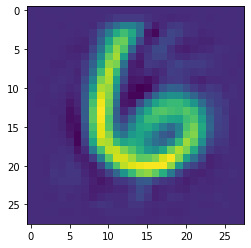

In [17]:
test_output_4 = model(test_image)
test_output_4 = test_output_4.cpu().detach().numpy()
test_output_4 = test_output_4.reshape(28,28)
plt.imshow(test_output_4)


In [18]:
MSE = np.sum(np.square(test_output_4 - test_image.cpu().data.numpy().reshape(28,28)))
print('After 300 epochs training, MSE = ', MSE)

After 300 epochs training, MSE =  22.317923


# What about non-digit image? (Anomal input)

(28, 28)

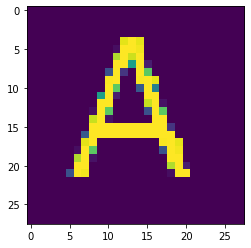

In [19]:
from PIL import Image
im = Image.open("/content/gdrive/My Drive/A.bmp")
p = np.array(im, dtype=float)/255
p = 1-p
p_down = p[::2,::2]
plt.imshow(p_down)
p_down.shape

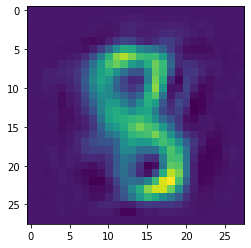

In [20]:
a_img = torch.from_numpy(p_down)
a_img = a_img.type(torch.FloatTensor)
a_img = a_img.cuda()
a_img=a_img.view(-1,784)
a_img.shape
# a_img = a_img.view(a_img.size(0), -1)
test_output_5 = model(a_img)
test_output_5 = test_output_5.cpu().detach().numpy()
test_output_5 = test_output_5.reshape(28,28)
plt.imshow(test_output_5)

In [21]:
MSE = np.sum(np.square(test_output_5 - test_image.cpu().data.numpy().reshape(28,28)))
print('For Alphabet A,  MSE = ', MSE)

For Alphabet A,  MSE =  45.01626
